Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


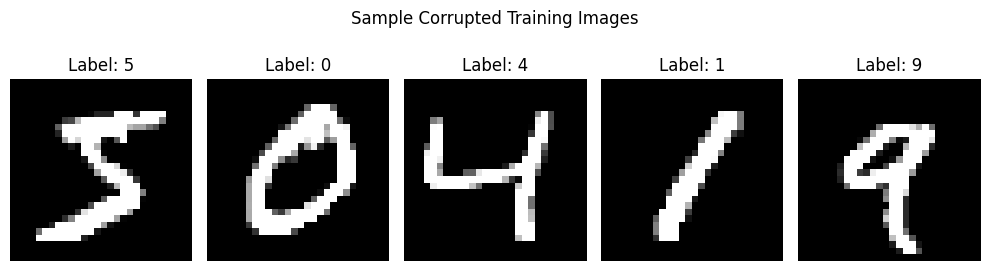

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 62ms/step - accuracy: 0.6316 - loss: 1.0732 - val_accuracy: 0.9613 - val_loss: 0.1299
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.9370 - loss: 0.2078 - val_accuracy: 0.9740 - val_loss: 0.0803
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - accuracy: 0.9544 - loss: 0.1504 - val_accuracy: 0.9807 - val_loss: 0.0644
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 46s 62ms/step - accuracy: 0.9621 - loss: 0.1247 - val_accuracy: 0.9846 - val_loss: 0.0536
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.9678 - loss: 0.1055 - val_accuracy: 0.9866 - val_loss: 0.0480
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.9725 - loss: 0.0934 - val_accuracy: 0.9858 - val_loss: 0.0459
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.9760 - loss: 0.0796 - val_accuracy: 0.9873 - val_loss: 0.0412
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.9773 - loss: 0.0743 - 

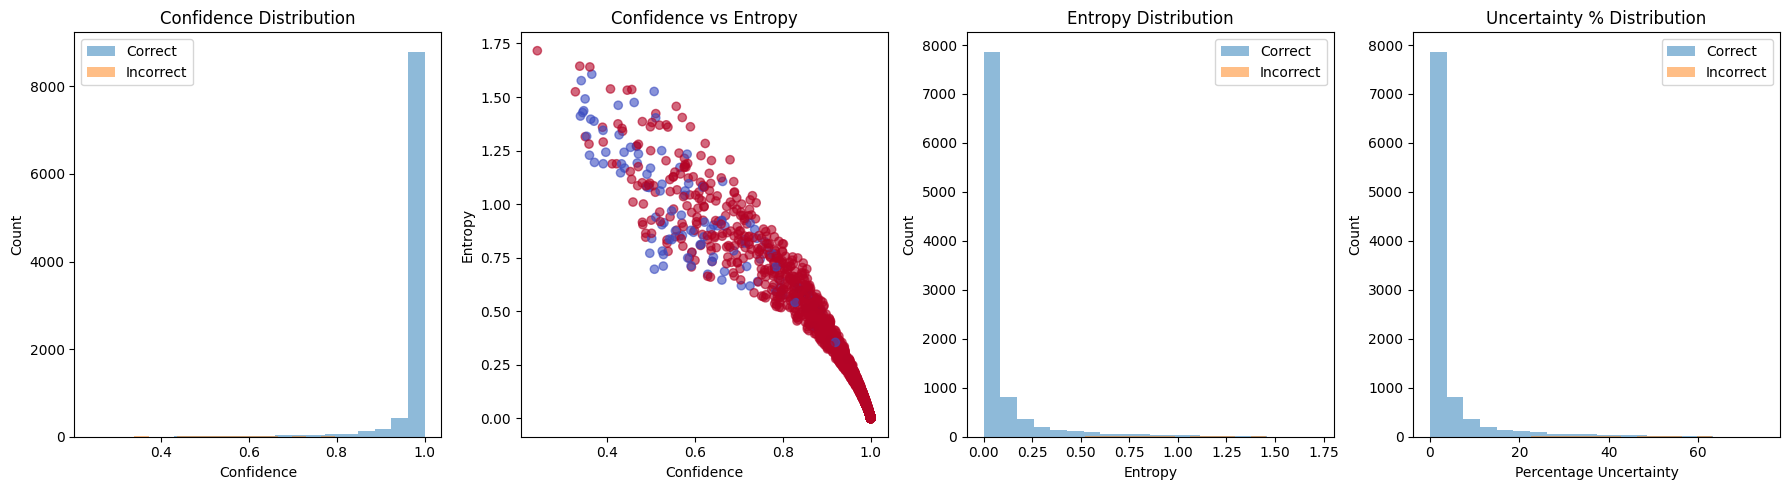

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model


np.random.seed(42)
tf.random.set_seed(42)

#Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

def load_corrupted_data():
    """Load corrupted data from mnist_c folder in Google Drive"""
    base_path = Path("/content/gdrive/MyDrive/STC710/mnist_c/brightness")  

    x_train = np.load(base_path / "train_images.npy")
    y_train = np.load(base_path / "train_labels.npy")
    x_test = np.load(base_path / "test_images.npy")
    y_test = np.load(base_path / "test_labels.npy")

    #adding channel dims and normalising
    x_train = x_train[..., None] / 255.0
    x_test = x_test[..., None] / 255.0

    return x_train, y_train, x_test, y_test

def visualize_corruptions(images, labels, n_samples=5, title=""):
    """Plot sample corrupted images"""
    plt.figure(figsize=(10, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def create_mc_dropout_model():
    """Create CNN with MC Dropout layers for uncertainty estimation"""
    inputs = Input(shape=(28, 28, 1))

    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)  # MC Dropout

    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)  # MC Dropout

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # MC Dropout

    outputs = Dense(10, activation='softmax')(x)

    return Model(inputs, outputs)

def train_model(model, x_train, y_train):
    """Train model on corrupted data"""
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(x_train, y_train,
                     batch_size=64,
                     epochs=10,
                     validation_split=0.2)

def mc_predict(model, x, n_samples=50):
    """Make MC Dropout predictions with uncertainty"""
    return np.stack([model(x, training=True) for _ in range(n_samples)])

def analyze_results(predictions, true_labels):
    """Analyze model performance on corrupted data with uncertainty quantification"""
    if predictions is None or len(predictions) == 0:
        raise ValueError("No predictions provided to analyze_results")

  
    mean_probs = np.mean(predictions, axis=0)
    preds = np.argmax(mean_probs, axis=1)
    std_dev = np.std(predictions, axis=0)

    #performance metrics
    accuracy = np.mean(preds == true_labels)
    entropies = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    max_entropy = -np.log(1 / 10)
    percentage_uncertainty = (entropies / max_entropy) * 100
    avg_std_dev = np.mean(std_dev, axis=1)
    percentage_uncertainty_std = np.mean(avg_std_dev) * 100

    print(f"Accuracy on corrupted data: {accuracy:.4f}")
    print(f"Average predictive entropy: {np.mean(entropies):.4f}")
    print(f"Average % uncertainty (entropy-based): {np.mean(percentage_uncertainty):.2f}%")
    print(f"Average % uncertainty (std-dev-based): {percentage_uncertainty_std:.2f}%")
    print(f"Error rate: {1 - accuracy:.4f}")

    # Visualizations
    plt.figure(figsize=(18, 5))

    confidences = np.max(mean_probs, axis=1)
    correct = preds == true_labels

    plt.subplot(1, 4, 1)
    plt.hist(confidences[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(confidences[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.xlabel("Confidence"), plt.ylabel("Count"), plt.legend()
    plt.title("Confidence Distribution")

    plt.subplot(1, 4, 2)
    plt.scatter(confidences, entropies, c=correct, cmap='coolwarm', alpha=0.6)
    plt.xlabel("Confidence"), plt.ylabel("Entropy")
    plt.title("Confidence vs Entropy")

    plt.subplot(1, 4, 3)
    plt.hist(entropies[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.xlabel("Entropy"), plt.ylabel("Count"), plt.legend()
    plt.title("Entropy Distribution")

    plt.subplot(1, 4, 4)
    plt.hist(percentage_uncertainty[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(percentage_uncertainty[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.xlabel("Percentage Uncertainty"), plt.ylabel("Count"), plt.legend()
    plt.title("Uncertainty % Distribution")

    plt.tight_layout()
    plt.show()

# ==== Main execution ====
try:
    # Load corrupted data
    x_train, y_train, x_test, y_test = load_corrupted_data()

    # Visualize some corrupted examples
    visualize_corruptions(x_train[:5] * 255, y_train[:5], title="Sample Corrupted Training Images")

    # Create and train model
    model = create_mc_dropout_model()
    history = train_model(model, x_train, y_train)

    # Evaluate with uncertainty estimation
    print("\nEvaluating on corrupted test data...")
    predictions = mc_predict(model, x_test)
    analyze_results(predictions, y_test)

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify files exist at: /content/gdrive/MyDrive/STC710/mnist_c/brightness/")
    print("2. Check file names: train_images.npy, train_labels.npy, test_images.npy, test_labels.npy")
    print("3. Ensure Drive is mounted properly")
    print("4. Check the image shape: expected (N, 28, 28) or (N, 28, 28, 1)")
